# Convolutional neural networks for artistic style transfer

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. It is meant to go along with a [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/) that provides more context, and explains a lot of the theory behind the steps that follow.

There will be a companion blog post and project coming soon in the future that implements a much faster version of this algorithm ([Johnson et al., 2016](https://arxiv.org/abs/1603.08155)) and wraps it in a webapp, a la [Prisma](https://prisma-ai.com).

In [1]:
!pip install scipy==1.1.0

In [2]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import os as os

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values
#-------------------------------#
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
 cd /content/drive/"My Drive"/"Colab Notebooks"/"Final_Project"

/content/drive/My Drive/Colab Notebooks/Final_Project


In [0]:
height = 512
width = 512

import random
list_5 = sorted(os.listdir('Data5'))
list_1 = sorted(os.listdir('Data1/Data1_for_style'))
random_num = 5
y=len(list_1)
content_image_path = []
for i in range(random_num):
  content_image_path.append('Data5/'+str(random.choice(list_5)))

In [7]:
for i, path in enumerate(list_1):
  print(path)

Style_1.jpg
Style_2.jpg
Style_3.jpg
Style_4.jpg


This code is going to compute model from 5 contents and 4 styles.
The final output will be 20 images
path -> Data5/Capture d’écran 2019-11-15 à 11.50.33.png
Content :1   style:1


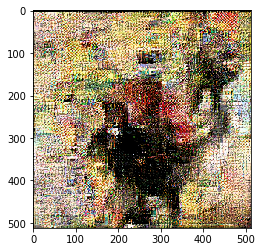

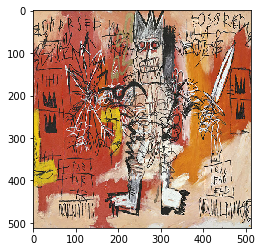

(512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)
(1, 512, 512, 3)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Start of iteration 1
Current loss value: 208402600000.0
Iteration 1 completed in 456s
Start of iteration 2
Current loss value: 103169770000.0
Iteration 2 completed in 454s
Start of iteration 3
Current loss value: 78475910000.0
Iteration 3 completed in 454s
Start of iteration 4
Current loss value: 69895290000.0
Iteration 4 completed in 454s
Start of iteration 5
Current loss value: 66535040000.0
Iteration 5 completed in 454s
Start of iteration 6
Current loss value: 64838480000.0
Iteration 6 completed in 464s
Start of iteration 7
Current loss value: 63984673000.0
Iteration 7 completed in 474s
Start of iteration 8


In [0]:
print('This code is going to compute model from %d contents and %d styles.\nThe final output will be %d images' % (random_num, y,random_num*y))
for i, path in enumerate(content_image_path):
  print('path -> '+ str(path))
  content_image_1 = Image.open(path)
  content_image_1 = content_image_1.resize((height, width))
  content_image_1 = content_image_1.convert('RGB')
  content_image_1

  for j, style in enumerate(list_1):
    print('Content :'+str(i+1)+'   style:'+str(j+1))
    style_image_path = 'Data1/Data1_for_style/'+str(style)
    style_image_1 = Image.open(style_image_path)
    style_image_1 = style_image_1.resize((height, width))
    style_image_1
    plt.imshow(content_image_1)
    plt.show()
    plt.imshow(style_image_1)
    plt.show()

    content_array= []
    content_array = np.asarray(content_image_1, dtype='float32')
    print(content_array.shape)
    content_array = np.expand_dims(content_array, axis=0) 
    print(content_array.shape)

    style_array = []
    style_array = np.asarray(style_image_1, dtype='float32')
    style_array = np.expand_dims(style_array, axis=0)

    #Subtract the mean RGB value  
    content_array[:, :, :, 0] -= 103.939
    content_array[:, :, :, 1] -= 116.779
    print(content_array.shape)
    content_array[:, :, :, 2] -= 123.68
    print(content_array.shape)
    content_array = content_array[:, :, :, ::-1]
    print(content_array.shape)

    style_array[:, :, :, 0] -= 103.939
    style_array[:, :, :, 1] -= 116.779
    style_array[:, :, :, 2] -= 123.68
    style_array = style_array[:, :, :, ::-1]
    print(style_array.shape)

    content_image = backend.variable(content_array)
    style_image = backend.variable(style_array)

    combination_image = backend.placeholder((1, height, width, 3))
  
    input_tensor = backend.concatenate([content_image,
                                      style_image,
                                      combination_image], axis=0)     # we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.
    model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)                                  
    layers = dict([(layer.name, layer.output) for layer in model.layers])

    content_weight = 0.025
    style_weight = 5.0
    total_variation_weight = 1.0

    loss = backend.variable(0.)

    layer_features = layers['block2_conv2']
    content_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(content_image_features,
                                          combination_features)
    
    feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
    for layer_name in feature_layers:
        layer_features = layers[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl

    loss += total_variation_weight * total_variation_loss(combination_image)
    #Define needed gradients and solve the optimisation problem
    grads = backend.gradients(loss, combination_image)
    #Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads.
    outputs = [loss]
    outputs += grads
    f_outputs = backend.function([combination_image], outputs)

    evaluator = Evaluator()

    #we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.
    x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

    iterations = 10

    for i in range(iterations):
        print('Start of iteration', i+1)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                        fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        end_time = time.time()
        print('Iteration %d completed in %ds' % (i+1, end_time - start_time))
    
    x = x.reshape((height, width, 3))
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')

    final = Image.fromarray(x)
    final.save('Data6/d6_con'+str(i+1)+'sty'+str(j+1)+'.png')
    print('d6_con'+str(i+1)+'sty'+str(j+1)+'   is saved')
    backend.clear_session()